# Predicting Apartment Renting Prices in Santiago MR - Model Prediction

In [1]:
import pandas as pd
import numpy as np
import joblib
import pickle
import re
import os
from datetime import datetime
from time import time
import json
import unidecode

import seaborn as sns
import plotly.express as px
from matplotlib import pyplot as plt
import matplotlib 
%matplotlib inline
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.tools as tls
import plotly.io as pio

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn import linear_model
import sklearn.metrics as metrics
import sklearn.utils
from xgboost import XGBRegressor

## Data Load: load cleaned data into a dataframe

Let's load the original dataset and split it once again into training and test sets.

In [2]:
df = pd.read_csv("RENT_APARTMENT_MR_eda.csv")
print(df.shape)
# df

(4762, 5)


In [3]:
train_ratio = 0.85
test_ratio = 0.15

# train_data = {}

# X = df[features[i]]
X = df.drop(['Price'], axis=1)
y = df['Price']

# split the data into train (train + validation) and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=test_ratio,
    random_state=22
)

frac_train = len(X_train) / (len(X_train)+len(X_test))
frac_test = len(X_test) / (len(X_train)+len(X_test))

print(f"Number of samples for training ({frac_train}): {len(X_train)}")
print(f"Number of samples for test ({frac_test}): {len(X_test)}")

Number of samples for training (0.8498530029399411): 4047
Number of samples for test (0.1501469970600588): 715


In [4]:
X_train
# X_test

,Surface,Bedrooms,Bathrooms,Location
4088,80.0,3.0,2.0,Santiago
2519,70.0,3.0,2.0,Maipu
3561,30.0,1.0,1.0,Santiago
862,500.0,3.0,4.0,Las Condes
932,304.0,4.0,4.0,Las Condes
...,...,...,...,...
2527,90.0,3.0,2.0,Macul
2952,50.0,1.0,1.0,Providencia
4587,113.0,2.0,2.0,Vitacura
356,68.0,2.0,2.0,Las Condes


## Make predictions

Let's now used the selected best-performing trained models to make predictions on the *Price* values in the training and test sets.

In order to use the selected models to make predictions we need to define once again the custom transformations we applied before on the training and test sets. When making predictions, these and the other transformations defined in the preprocessing pipeline will be applied to the input data the models are fed with. 

In [5]:
class CustomOrdinalEncoder(TransformerMixin, BaseEstimator):
    """
    Class defining a custom transformer that applies ordinal encoding.
    For any given feature in the input dataset, this transformation assigns 
    the value of the defined threshold to values which are higher the threshold.
    While feature values which lower or equal than the threshold are kept 
    unchanged.

    Parameters
    ----------
    TransformerMixin: class
        Implements method fit_transform().
    BaseEstimator: class
        Implements methods set_params() and get_params().

    Returns
    -------
        pandas.dataframe
        Dataframe containing transformed data.                
    """      
    def __init__(self, threshold=None):
        self.threshold = threshold
        
    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        """Apply ordinal encoding transformation to input dataset."""        
#         print(type(X))
        if isinstance(X, pd.DataFrame):
            # convert dataframe to series
            X = X.squeeze('columns').copy()
#         print(X.columns)
        else:
            X = pd.Series(X).copy()
#         print(type(X))
#         print(X)        
        X = X.apply(
            lambda x: int(x) if x < self.threshold else int(self.threshold)
        )
#         print(X.shape)
#         print(type(X))
        return X.to_frame()

class DimensionReducer(BaseEstimator,TransformerMixin):
    """
    Class defining a custom transformer that applies dimensionality reduction.
    For any given feature in the input dataset, this transformation assigns 
    the value 'value_lower' to values with count lower than the defined 'threshold'.
    While feature values with count higher or equal than the 'threshold' are 
    kept unchanged. 

    Parameters
    ----------
    TransformerMixin: class
        Implements method fit_transform().
    BaseEstimator: class
        Implements methods set_params() and get_params().
    threshold: int
        Cutoff value of feature count.
    value_lower: int or str
        Value used to replace transformed feature values.

    Returns
    -------
        pandas.dataframe
        Dataframe containing transformed data.                
    """      
    def __init__(self, threshold=None, value_lower=None):
        self.threshold = threshold
        self.value_lower = value_lower     
        
    def feature_selector(self,X,y=None):
        """Define dimensionality reduction transformation."""                        
        if isinstance(X, pd.DataFrame):
            # convert dataframe to series
            X = X.squeeze('columns').copy()         
        else:
            X = pd.Series(X).copy()
#         print(type(X))        
#         print(X)
        series_feature = X.value_counts(ascending=False)
#         print(series_feature)
        self.series_feature_above = series_feature[series_feature >= self.threshold]
        self.series_feature_below = series_feature[series_feature < self.threshold]
        print(f"Total categories in feature: {len(series_feature)}")
        print(f"Total categories in feature (above threshold = {self.threshold}): {len(self.series_feature_above)}")
        print(f"Total categories in feature (below threshold = {self.threshold}): {len(self.series_feature_below)}")          

    def fit(self,X,y=None):
        """Fit dimensionality reduction transformation to the input dataset."""                                
        self.feature_selector(X)
        return self
    
    def transform(self,X,y=None):
        """Apply dimensionality reduction transformation to input dataset."""                
        if isinstance(X, pd.DataFrame):
            # convert dataframe to series
            X = X.squeeze('columns').copy()        
        else:
            X = pd.Series(X).copy()        
#         print(type(X))                
#         print(X)
        X = X.apply(
            lambda x: self.value_lower if x in self.series_feature_below else x
        )        
        return X.to_frame()

We also define a function that allows us to load the implemented preprocessing pipeline, the selected models, and other necessary artifacts for our analysis.  

In [6]:
def load_saved_artifacts():
    """
    Load previously saved artifacts such as preprocessing pipeline and selected models. 

    Returns
    -------
        tuple
        Containing preprocessing pipeline, selected models and their corresponding features, and 
        a list including available apartment locations.   
    """  
    pipeline = joblib.load('pipe_all.pkl')        
    features = joblib.load('RENT_APARTMENT_MR_features.pkl')
    locations = sorted(joblib.load('list_location_encoded.pkl'))
    
    models = []
    model_features = []
    fs = ['model_xgb_f15_t436.pkl', 'model_xgb_f15_t474.pkl']
    
    for f in fs:
        key_feature = int(f.split('_f')[-1][:2])
        model_features.append(features[key_feature])
        models.append(joblib.load(f))
    
    return pipeline, models, model_features, locations

In [7]:
pipeline, models, features, locations = load_saved_artifacts()

In [8]:
locations
# features
# models
# pipeline

['AAA',
 'Estacion Central',
 'Independencia',
 'La Cisterna',
 'La Florida',
 'Las Condes',
 'Lo Barnechea',
 'Macul',
 'Nunoa',
 'Providencia',
 'San Miguel',
 'Santiago',
 'Vitacura']

Let's use now the selected models to make predictions on both the training and test sets.
The final predictions will be calculated as the average of the predictions obtained from the two selected models.

### Predictions on training set

In [9]:
df_train = X_train.copy()
df_train['Price'] = y_train

for i, model in enumerate(models):
    idx_features = [int(j) for j in features[i]]
    x = pipeline.transform(df_train).toarray()
    x = x[:, idx_features]
    print(x.shape)
    preds = model.predict(x)
    df_train[f"Price_pred_{i+1:02}"] = models[i].predict(x)

pred_cols = [c for c in df_train.columns.values if 'pred' in c]
df_train['Price_pred'] = df_train[pred_cols].mean(axis=1)
df_train

(4047, 15)
(4047, 15)


,Surface,Bedrooms,Bathrooms,Location,Price,Price_pred_01,Price_pred_02,Price_pred
4088,80.0,3.0,2.0,Santiago,620000.0,5.786366e+05,5.704843e+05,574560.500
2519,70.0,3.0,2.0,Maipu,730000.0,6.088070e+05,5.866374e+05,597722.250
3561,30.0,1.0,1.0,Santiago,300000.0,3.211710e+05,3.188542e+05,320012.625
862,500.0,3.0,4.0,Las Condes,3900000.0,3.852098e+06,3.711778e+06,3781938.000
932,304.0,4.0,4.0,Las Condes,2950000.0,3.003076e+06,2.970191e+06,2986633.500
...,...,...,...,...,...,...,...,...
2527,90.0,3.0,2.0,Macul,720000.0,7.058474e+05,7.070493e+05,706448.375
2952,50.0,1.0,1.0,Providencia,571431.0,5.689129e+05,5.674447e+05,568178.750
4587,113.0,2.0,2.0,Vitacura,1000000.0,1.360886e+06,1.305332e+06,1333109.250
356,68.0,2.0,2.0,Las Condes,1000000.0,1.097982e+06,1.128578e+06,1113280.250


### Predictions on test set

In [10]:
df_test = X_test.copy()
df_test['Price'] = y_test

for i, model in enumerate(models):
    idx_features = [int(j) for j in features[i]]
    x = pipeline.transform(df_test).toarray()
    x = x[:, idx_features]
    print(x.shape)
    preds = model.predict(x)
    df_test[f"Price_pred_{i+1:02}"] = models[i].predict(x)

pred_cols = [c for c in df_test.columns.values if 'pred' in c]
df_test['Price_pred'] = df_test[pred_cols].mean(axis=1)
df_test

(715, 15)
(715, 15)


/home/hugo/local/anaconda3/envs/ml_tensorflow/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning:

Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros

/home/hugo/local/anaconda3/envs/ml_tensorflow/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning:

Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros



,Surface,Bedrooms,Bathrooms,Location,Price,Price_pred_01,Price_pred_02,Price_pred
4548,43.0,1.0,1.0,Vitacura,698415.0,6.862996e+05,6.715538e+05,6.789267e+05
5,94.0,3.0,2.0,Las Condes,870000.0,1.085381e+06,1.087091e+06,1.086236e+06
4341,129.0,3.0,2.0,Vitacura,2900000.0,1.859169e+06,1.817461e+06,1.838315e+06
1975,64.0,2.0,1.0,La Florida,530000.0,4.568517e+05,4.455544e+05,4.512030e+05
86,46.0,1.0,2.0,Las Condes,890162.0,8.339199e+05,7.889622e+05,8.114410e+05
...,...,...,...,...,...,...,...,...
4665,170.0,2.0,4.0,Vitacura,1800000.0,1.847475e+06,1.826669e+06,1.837072e+06
1463,72.0,2.0,2.0,Nunoa,650000.0,7.023691e+05,6.872286e+05,6.947989e+05
922,377.0,5.0,4.0,Las Condes,4285729.0,2.856534e+06,2.739902e+06,2.798218e+06
2967,50.0,1.0,1.0,Providencia,530000.0,5.689129e+05,5.674447e+05,5.681788e+05


## Prediction Analysis

Next, we will examine the model predictions on the training and test sets. 
For this we define some functions that implement the necessary steps to create useful figures displaying the geospatial distribution of the predictions in the available locations.

In [11]:
def get_geometry(path_geojson, region):
    """
    Retrieve geographical features from a GeoJSON file and a given region.  

    Parameters
    ----------
    path_geojson: str
        Path to input GeoJSON file.
    region: str
        Region for which geographical features are extracted.

    Returns
    -------
        tuple
        Containing extracted GeoJSON features for the specified region, 
        and a dictionary including ids of the cities in that region.   
    """     
    
    # load geojson
    with open(path_geojson) as f:
        geojson_in = json.load(f)        
#     print(len(geojson_in['features']))
    
    geojson_out = {
        'type': geojson_in['type'],
        'name': geojson_in['name'],    
        'features': []
    }
    comunas_id = {}

    for i in range(len(geojson_in['features'])):

        reg = geojson_in['features'][i]['properties']['Region']
        if unidecode.unidecode(reg) != "Region Metropolitana de Santiago": # change to 'region'
            continue

        geojson_out['features'].append(geojson_in['features'][i])

        city = geojson_in['features'][i]['properties']['Comuna']
        city = unidecode.unidecode(city).split('-')[-1]
        obj_id = str(geojson_in['features'][i]['properties']['objectid'])
#         print(city, obj_id)
        geojson_out['features'][-1]['properties']['Comuna'] = f"{obj_id}-{city}"
        geojson_out['features'][-1]['id'] = obj_id
        comunas_id[city] = obj_id  
    
    return geojson_out, comunas_id

In [12]:
# load geojson containing cities of interest
path_geojson = "chile_comunas.geojson"
region = "Region Metropolitana de Santiago"
geojson_mr, dct_locations = get_geometry(path_geojson, region)

# save geojson containing cities of interest
with open('chile_comunas_MR.geojson', 'w') as f:
    json.dump(geojson_mr, f)

In [13]:
dct_locations
# len(geojson_mr['features'])
# geojson_mr

{'SAN JOAQUIN': '330',
 'SAN MIGUEL': '331',
 'SAN RAMON': '332',
 'INDEPENDENCIA': '309',
 'LA CISTERNA': '310',
 'PENALOLEN': '323',
 'PROVIDENCIA': '324',
 'LA REINA': '314',
 'CALERA DE TANGO': '295',
 'COLINA': '288',
 'SANTIAGO': '333',
 'LAMPA': '289',
 'PIRQUE': '291',
 'PUENTE ALTO': '292',
 'HUECHURABA': '308',
 'SAN BERNARDO': '297',
 'CURACAVI': '299',
 'MARIA PINTO': '300',
 'CERRILLOS': '303',
 'CERRO NAVIA': '304',
 'VITACURA': '334',
 'CONCHALI': '305',
 'EL BOSQUE': '306',
 'ESTACION CENTRAL': '18258',
 'LA FLORIDA': '311',
 'LA GRANJA': '312',
 'LA PINTANA': '313',
 'LAS CONDES': '315',
 'LO BARNECHEA': '316',
 'LO ESPEJO': '317',
 'LO PRADO': '318',
 'MACUL': '319',
 'MAIPU': '320',
 'NUNOA': '321',
 'PEDRO AGUIRRE CERDA': '322',
 'PUDAHUEL': '325',
 'QUILICURA': '326',
 'QUINTA NORMAL': '327',
 'RECOLETA': '328',
 'RENCA': '329',
 'EL MONTE': '335',
 'PADRE HURTADO': '337',
 'PENAFLOR': '338',
 'TALAGANTE': '339',
 'PAINE': '296',
 'ISLA DE MAIPO': '336',
 'BUIN': '

In [14]:
list_location_geojson = list(dct_locations)
joblib.dump(list_location_geojson, "list_location_geojson.pkl")

['list_location_geojson.pkl']

In [15]:
def calculate_dataframe(df, dct_locations, features, z_feature, z_min, z_max):
    """
    For each of the given 'features' in a dataframe 'df', this function calculates the mean of the 
    feature values grouped by location, but only for rows which satisfy a condition applied to the 
    feature 'z_feature'.
    The condition applied to 'z_feature' filters out values which are lower than 'z_min' and 
    higher than 'z_max'.        
    
    Parameters
    ----------
    df: pandas.dataframe
        Dataframe containing features 'features' and 'z_feature'.    
    dct_locations: dict
        Dictionary including ids of the cities in the region of interest. 
    features: list
        Columns in 'df' whose values will be used to calculate the mean.
    z_feature: str
        Column in 'df' whose values will be used to filter out data rows.       
    z_min, z_max: float, float
        Minimum and maximum 'z_feature' values used to filter out data rows.

    Returns
    -------
        tuple
        Containing extracted GeoJSON features for the specified region and a dictionary 
        including ids of the cities in that region.   
    """
    # apply condition to filter dataframe
    cond = (df[z_feature] >= z_min) & (df[z_feature] < z_max)
    
    # calculate mean of features values grouped by location
    dct = {
        f"{f}_mean": df[cond].groupby(['Location'])[f].mean().astype(int)
        for f in features
    }
    
    # add NaN values to account for from locations which are not present in dataframe
    locations_out = [
        (l.title(), dct_locations[l.upper()]) for l in dct_locations
        if l not in sorted([l.upper() for l in dct[f"{features[0]}_mean"].index.values])
    ]
    locations_out_id = [l[1] for l in locations_out]
    locations_out = [l[0] for l in locations_out]    
#     print(len(locations_out))

    for k in dct:
        s = pd.Series([np.nan]*len(locations_out), index=locations_out)
        dct[k] = pd.concat([dct[k], s])

    df2 = pd.DataFrame(dct)
    
    # calculate residual between selected features
    df2[f"{features[0]}_res_mean"] = -1 * df2.diff(axis=1).iloc[:, -1].values    
    
    # calculate residual between selected features (% of true values)    
    df2[f"{features[0]}_res_mean_pce"] = 100 * df2[f"{features[0]}_res_mean"] / df2[f"{features[0]}_mean"] 
    df2 = df2.round({f"{features[0]}_res_mean_pce": 2})
    
    # add information about locations
    df2['Location'] = df2.index.values
    df2['Location_count'] = df[cond].groupby(['Location'])['Location'].count()        
    df2 = df2.reset_index(drop=True)
#     df2['Location_count_2'] = df[cond].groupby(['Location'])['Location'].count()    
    locations_in = [(l, dct_locations[l.upper()]) for l in df2['Location'].values]
    locations_in_id = [l[1] for l in locations_in]
    df2['Location_id'] = locations_in_id
    
    return df2

def get_geocenter(geojson):
    """
    Retrieve geographical center of features in a given GeoJSON data.
    
    Parameters
    ----------
    geojson: GeoJSON
        Geographical features.

    Returns
    -------
        dict
        Containing longitude and latitude of the calculated geographical center.       
    """   
    # iterate over GeoJSON features
    features_in = [f for f in geojson['features']]
#     print(len(features_in))
    coords = np.array([])
    for feature in features_in:
        coords_in = np.array(feature['geometry']['coordinates'][0])
        if coords_in.ndim in [1,3]:
            coords_in = np.array(feature['geometry']['coordinates'][0][0])
        try:
            coords = np.vstack((coords, coords_in))
        except ValueError:
            coords = coords_in
            
    # lon_mean, lat_mean = coords.mean(axis=0)
    lon_min, lat_min = coords.min(axis=0)
    lon_max, lat_max = coords.max(axis=0)
    lon_mean = (lon_min + lon_max)*.5
    lat_mean = (lat_min + lat_max)*.5
    dct_center = {'lon': lon_mean, 'lat': lat_mean}
    return dct_center

In [16]:
def create_maps(df, geojson, features, colorscales, renderer, save_file=None):
    """
    Generate a figure displaying choropleth maps of selected features in a given dataframe.
        
    Parameters
    ----------
    df: pandas.dataframe
        Dataframe containing selected features.
    geojson: GeoJSON
        Geographical features in which features values will be shown.
    features: list
        Columns in 'df' which values will be displayed in the figure maps.
    colorscales: list
        Color scales used to plot values from corresponding features. 
    renderer: str
        Plotly renderer to show figure (see https://plotly.com/python/renderers/).
    save_file: str
        If not None, figure will be saved to fully self-contained HTML file of name 'save_file'.
    """
    
    rows = 1
    cols = len(features)
    
    colors_plot = []
    
    # color scale for left-hand subplot
    colors = px.colors.get_colorscale(colorscales[0])
    colors_plot.append(
        [[0.0, 'gray']] + [[0.01, colors[0][1]]] + colors[1:]
    ) 

    # color scale for right-hand subplot
    colors = px.colors.get_colorscale(colorscales[1])
    # c = [[0.0, 'gray']] + [[0.01, colors[0][1]]] + colors[1:]
    colors_plot.append(
        colors[:5] + [[0.4995, colors[5][1]]] + [[0.49951, 'gray']] + [[0.50049, 'gray']] + [[0.5005, colors[5][1]]] + colors[6:]
    )
      
    # map parameters
    map_center = get_geocenter(geojson)
    map_zoom = 8
    map_opacity = .7
#     map_center = {
#         'lon': -70.67159, 
#         'lat': -33.47636
#     }
#     print(map_center)
    locations = "Location_id"
    hover_data = ["Location"]

    # plotting
    fig = make_subplots(
        rows=rows,
        cols=cols,
#         specs = [[{'type': 'choropleth'} for c in np.arange(cols)] for r in np.arange(rows)],
        specs = [[{'type': 'choroplethmapbox'} for c in np.arange(cols)] for r in np.arange(rows)],                        
#         horizontal_spacing = 0.025,
#         vertical_spacing = 0.01
    )

    nrow, ncol = 1, 1
    
    for i in range(len(features)):
    
        coloraxis = 'coloraxis'
        subplot = 'mapbox'
        
        if ncol > 1:
            coloraxis = f"{coloraxis}{ncol}"
            subplot = f"{subplot}{ncol}"
        
        fig.add_trace(
            go.Choroplethmapbox(
                locations=df['Location_id'],
                featureidkey='id',
                z=df[features[i]],
                geojson=geojson,
                coloraxis = coloraxis,
                hoverinfo='text',
                hovertext=df[['Location',features[i],'Location_count']],
                marker={
                    'opacity': map_opacity
                },
                subplot=subplot
            ),
            row = nrow,
            col = ncol
        )    
        
        ncol += 1 
        
    # figure axes configuration
    fig.update_layout(
        margin={"r":0,"t":0,"l":0,"b":0},
        mapbox={
            'style':'carto-positron',
            'center':map_center,
            'zoom':map_zoom,
        },
        mapbox2={
            'style':'carto-positron',
            'center':map_center,
            'zoom':map_zoom,
        },
        coloraxis={
            'colorbar': {
                'title': features[0],
                'x': .45,
            },
            'cmin': -5,
            'cmax': df[features[0]].max(),
            'colorscale': colors_plot[0],
        },     
        coloraxis2={
            'colorbar': {
                'title': features[1],
                'x': 1.,
            },
            'colorscale': colors_plot[1],            
            'cmin': -20,
            'cmax': 20,            
#             'cauto': True,
#             'cmid': 0.,            
        }
    )
#     fig.show()
#     print(fig.layout)

    if isinstance(save_file, str):
        fig.write_html(f"{save_file}.html")

    if renderer == 'notebook':
        # show interactive figure
        fig.show(renderer=renderer)
        # show static figure
    elif renderer in ['jpg', 'png', 'svg']:
        fig.show(renderer=renderer, width=1000, height=500)

In [17]:
def add_dataframe_to_geojson(df, geojson, id_column, add_columns=[], add_suffix=None, in_place=True):
    """
    Add selected dataframe columns as properties of features with matching id in a given GeoJSON file.

    Parameters
    ----------
    df: pandas.dataframe
        Dataframe containing columns to be added to GeoJSON. 
    geojson: dict
        Dictionary containing GeoJSON features.
    id_column: str
        Column including id which should match any GeoJSON feature id.          
    add_columns: list of str
        Columns to be added as GeoJSON feature properties.
    add_suffix: str
        Suffix used as ending for added GeoJSON feature properties. 
        Resulting GeoJSON feature properties will have names in the format: 
        'dataframe column name' + 'add_suffix'.
    in_place: bool
        Controls how GeoJSON will be updated.
        True will update GeoJSON in place. False will update a copy of original GeoJSON. 
        
    Returns
    -------
        geojson_out: dict
        Contains updated GeoJSON features including additional properties.   
    """     
    
    if in_place:
        geojson_out = geojson
    else:
        geojson_out = geojson.copy()

    for i in range(len(geojson_out['features'])):

        feature_id = geojson_out['features'][i]['id']
        df_tmp = df[df[id_column] == feature_id]
        
        for c in add_columns:
            property_name = f"{c}"

            if add_suffix:
                property_name += f"_{add_suffix}"
                
            geojson_out['features'][i]['properties'][property_name] = df_tmp[c].values[0]

    return geojson_out

Let's take a look at the distribution of data in the training and test sets, disaggregated by location. This information will be useful to explain some of the results observed from the predicted apartment rent prices...

Text(0.5, 1.0, 'Test set')

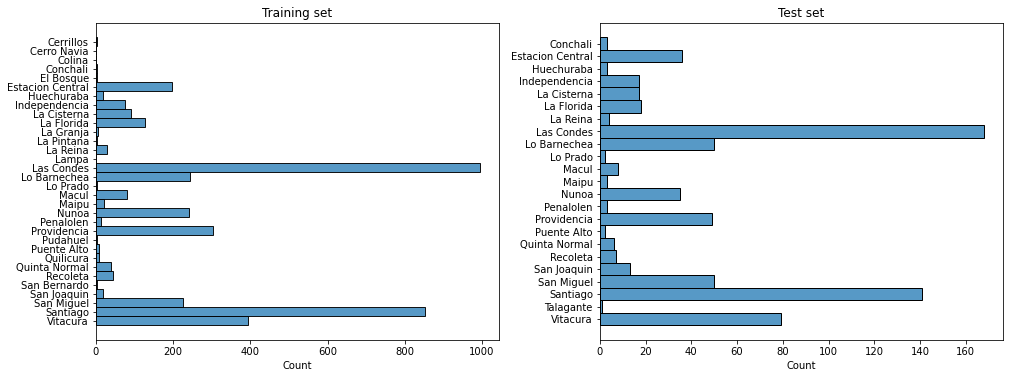

In [18]:
nrows, ncols = 1, 2

fig = plt.figure(figsize=(7.*ncols, 5.*nrows))
plt.subplots_adjust(wspace=.25, hspace=.2, bottom=0, left=0)

ax = fig.add_subplot(nrows, ncols, 1)
sns.histplot(data=df_train.sort_values(by=['Location'], ascending=True), y="Location")
ax.set_ylabel('')
ax.set_title('Training set')

ax = fig.add_subplot(nrows, ncols, 2)
sns.histplot(data=df_test.sort_values(by=['Location'], ascending=True), y="Location")
ax.set_ylabel('')
ax.set_title('Test set')

We create two-panel figures which display the apartment rent prices (*Price_mean*, left-hand panel) and the residual (as percentage of true prices) between the true and predicted rent prices (*Price_res_mean_pce*, right-hand panel), averaged by location.  

In a previous notebook we had identified the apartment *Surface* as the most important *Price* predictor, besides *Location*, thus we create different figures for specific ranges of *Surface* values, which allow us to examine in more detail the interplay between these two predictor features in terms of the observed predictions.

When the mouse hovers over each map location (when using `renderer='notebook'` in function `create_maps`), a text is displayed, which correspond to *Location, Price_mean, Location_count* in the left-hand panel and to *Location, Price_res_mean_pce, Location_count* in the right-hand panel.
Map locations where there is no data in each interval of *Surface* values, i.e. where *Location_count = 0*, are shown in gray.

### Predictions on training set: 0 < *Surface* < 50 [m2]

In [19]:
dct_fillna = {
    'Price_mean': -99999,
    'Price_pred_mean': -99999,
    'Price_res_mean': 0.,
    'Price_res_mean_pce': 0.,
    'Location_count': 0.
}

In [20]:
df_train_surface_0_50 = calculate_dataframe(
    df_train, 
    dct_locations, 
    features=['Price','Price_pred'], 
    z_feature='Surface', 
    z_min=0., 
    z_max=50.
)
df_train_surface_0_50_nonan = df_train_surface_0_50.fillna(value=dct_fillna)
df_train_surface_0_50_nonan.sort_values(by=['Location_count'], ascending=False)

,Price_mean,Price_pred_mean,Price_res_mean,Price_res_mean_pce,Location,Location_count,Location_id
23,354708.0,353469.0,1239.0,0.35,Santiago,597.0,333
0,326896.0,327044.0,-148.0,-0.05,Estacion Central,159.0,18258
22,384288.0,377962.0,6326.0,1.65,San Miguel,129.0,331
7,679390.0,673039.0,6351.0,0.93,Las Condes,89.0,315
12,478420.0,471933.0,6487.0,1.36,Nunoa,87.0,321
2,346814.0,352863.0,-6049.0,-1.74,La Cisterna,62.0,310
14,569136.0,556615.0,12521.0,2.20,Providencia,60.0,324
3,388200.0,375852.0,12348.0,3.18,La Florida,57.0,311
1,329136.0,332682.0,-3546.0,-1.08,Independencia,56.0,309
10,392546.0,386858.0,5688.0,1.45,Macul,31.0,319


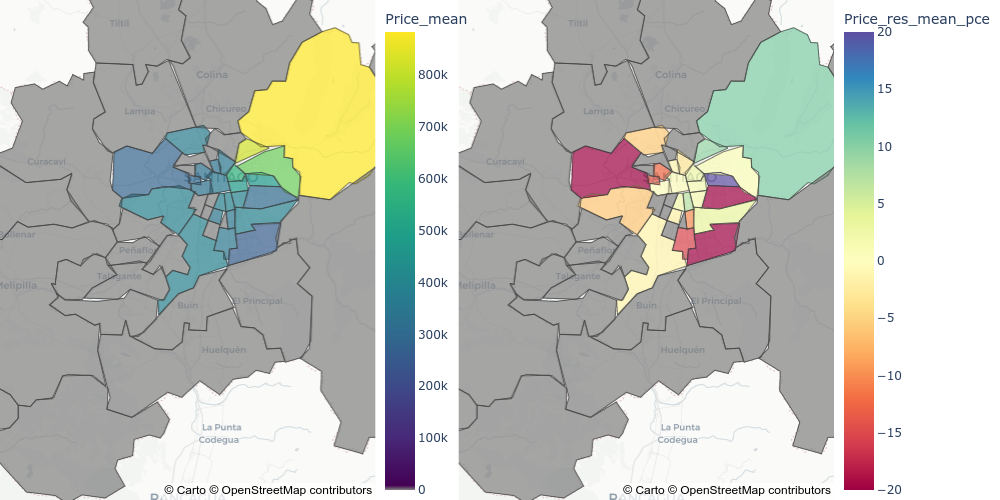

In [21]:
create_maps(
    df_train_surface_0_50_nonan, 
    geojson_mr, 
    features=['Price_mean','Price_res_mean_pce'], 
    colorscales=['viridis', 'spectral'],
    renderer='png',
    save_file='fig_price_train_surface_0_50'
)

### Predictions on training set: 50 < *Surface* < 100 [m2]

In [22]:
df_train_surface_50_100 = calculate_dataframe(
    df_train, 
    dct_locations, 
    features=['Price','Price_pred'], 
    z_feature='Surface', 
    z_min=50., 
    z_max=100.
)
df_train_surface_50_100_nonan = df_train_surface_50_100.fillna(value=dct_fillna)
df_train_surface_50_100_nonan.sort_values(by=['Location_count'], ascending=False)

,Price_mean,Price_pred_mean,Price_res_mean,Price_res_mean_pce,Location,Location_count,Location_id
13,1039267.0,1034802.0,4465.0,0.43,Las Condes,289.0,315
27,493492.0,487106.0,6386.0,1.29,Santiago,221.0,333
19,790152.0,783310.0,6842.0,0.87,Providencia,146.0,324
17,691173.0,679025.0,12148.0,1.76,Nunoa,146.0,321
26,507331.0,502923.0,4408.0,0.87,San Miguel,96.0,331
14,948051.0,934167.0,13884.0,1.46,Lo Barnechea,75.0,316
8,494831.0,493722.0,1109.0,0.22,La Florida,70.0,311
28,1065826.0,1063750.0,2076.0,0.19,Vitacura,64.0,334
15,544409.0,532710.0,11699.0,2.15,Macul,49.0,319
4,414594.0,426584.0,-11990.0,-2.89,Estacion Central,37.0,18258


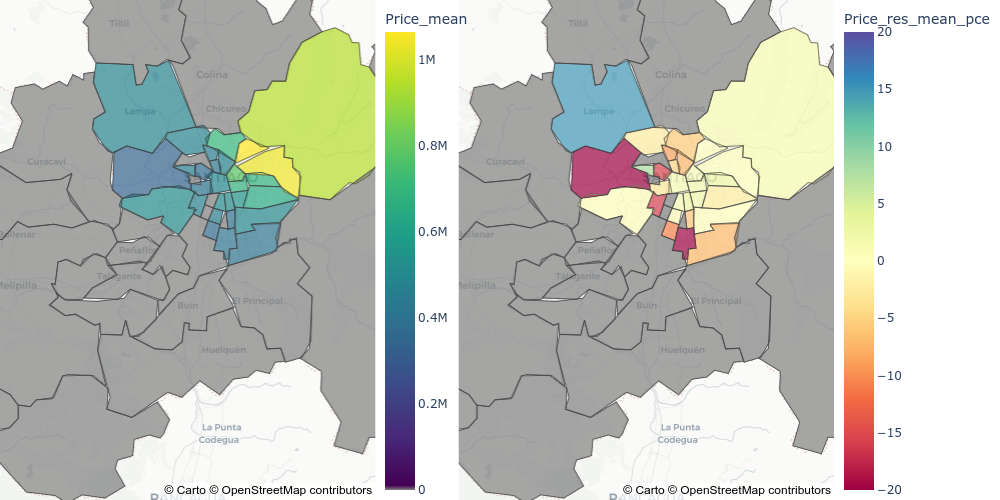

In [23]:
create_maps(
    df_train_surface_50_100_nonan, 
    geojson_mr, 
    features=['Price_mean','Price_res_mean_pce'], 
    colorscales=['viridis', 'spectral'],
    renderer='png',
    save_file='fig_price_train_surface_50_100'
)

### Predictions on training set: 100 < *Surface* < 600 [m2]

In [24]:
df_train_surface_100_600 = calculate_dataframe(
    df_train, 
    dct_locations, 
    features=['Price','Price_pred'], 
    z_feature='Surface', 
    z_min=100., 
    z_max=600.
)
df_train_surface_100_600_nonan = df_train_surface_100_600.fillna(value=dct_fillna)
df_train_surface_100_600_nonan.sort_values(by=['Location_count'], ascending=False)

,Price_mean,Price_pred_mean,Price_res_mean,Price_res_mean_pce,Location,Location_count,Location_id
5,2038848.0,2020775.0,18073.0,0.89,Las Condes,617.0,315
14,2090595.0,2066536.0,24059.0,1.15,Vitacura,325.0,334
6,2466663.0,2438705.0,27958.0,1.13,Lo Barnechea,161.0,316
10,1354232.0,1341553.0,12679.0,0.94,Providencia,98.0,324
13,1060400.0,1064042.0,-3642.0,-0.34,Santiago,33.0,333
4,1450000.0,1391395.0,58605.0,4.04,La Reina,11.0,314
8,830139.0,895202.0,-65063.0,-7.84,Nunoa,8.0,321
1,1043426.0,1094730.0,-51304.0,-4.92,Huechuraba,7.0,308
9,945107.0,1113273.0,-168166.0,-17.79,Penalolen,6.0,323
11,873373.0,1108096.0,-234723.0,-26.88,Recoleta,2.0,328


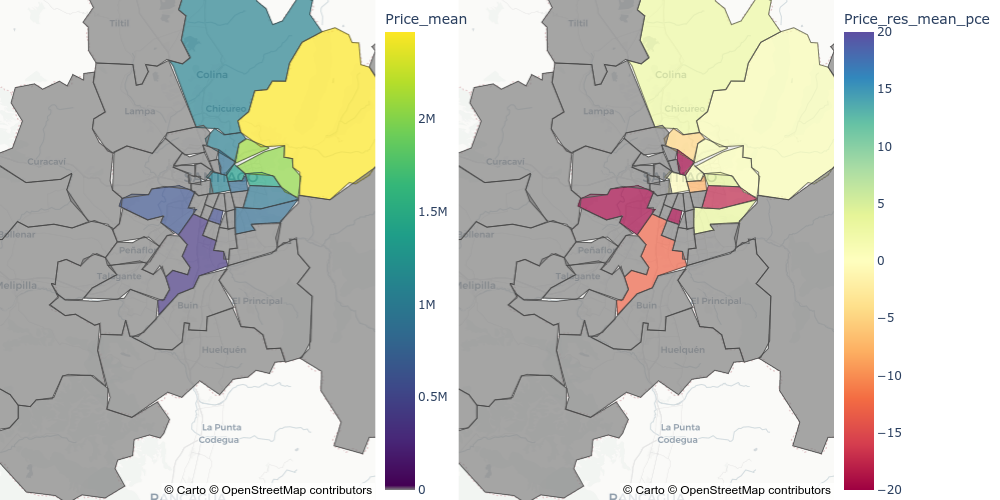

In [25]:
create_maps(
    df_train_surface_100_600_nonan, 
    geojson_mr, 
    features=['Price_mean','Price_res_mean_pce'], 
    colorscales=['viridis', 'spectral'],
    renderer='png',
    save_file='fig_price_train_surface_100_600'
)

### Predictions on test set: 0 < *Surface* < 50 [m2]

In [26]:
df_test_surface_0_50 = calculate_dataframe(
    df_test, 
    dct_locations, 
    features=['Price','Price_pred'], 
    z_feature='Surface', 
    z_min=0., 
    z_max=50.
)
df_test_surface_0_50_nonan = df_test_surface_0_50.fillna(value=dct_fillna)
df_test_surface_0_50_nonan.sort_values(by=['Location_count'], ascending=False)

,Price_mean,Price_pred_mean,Price_res_mean,Price_res_mean_pce,Location,Location_count,Location_id
15,345090.0,344832.0,258.0,0.07,Santiago,91.0,333
1,335466.0,333140.0,2326.0,0.69,Estacion Central,32.0,18258
14,384598.0,368061.0,16537.0,4.30,San Miguel,32.0,331
5,653942.0,680612.0,-26670.0,-4.08,Las Condes,19.0,315
8,440055.0,455789.0,-15734.0,-3.58,Nunoa,17.0,321
3,361714.0,365113.0,-3399.0,-0.94,La Cisterna,14.0,310
2,345573.0,334210.0,11363.0,3.29,Independencia,13.0,309
13,369909.0,353898.0,16011.0,4.33,San Joaquin,11.0,330
4,416200.0,396339.0,19861.0,4.77,La Florida,10.0,311
9,644286.0,585089.0,59197.0,9.19,Providencia,9.0,324


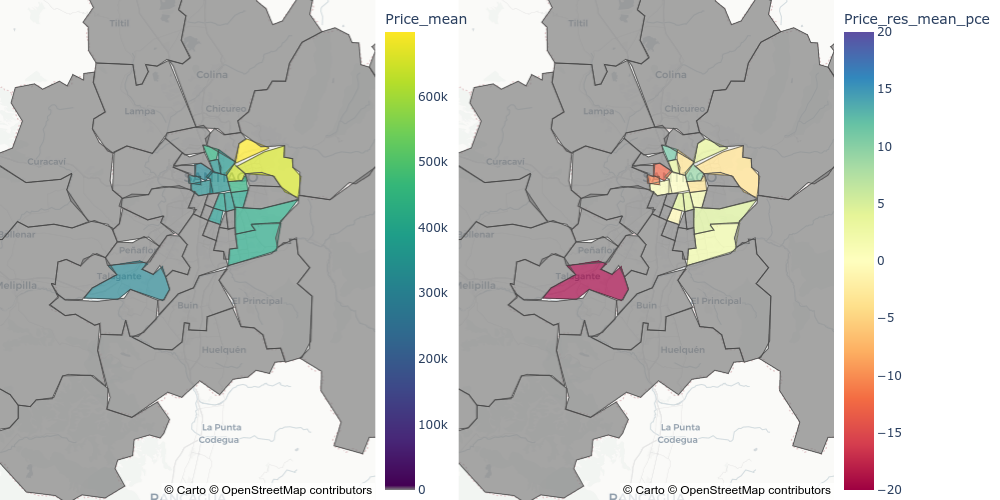

In [27]:
create_maps(
    df_test_surface_0_50_nonan, 
    geojson_mr, 
    features=['Price_mean','Price_res_mean_pce'], 
    colorscales=['viridis', 'spectral'],
    renderer='png',
    save_file='fig_price_test_surface_0_50'
)

### Predictions on test set: 50 < *Surface* < 100 [m2]

In [28]:
df_test_surface_50_100 = calculate_dataframe(
    df_test, 
    dct_locations, 
    features=['Price','Price_pred'], 
    z_feature='Surface', 
    z_min=50., 
    z_max=100.
)
df_test_surface_50_100_nonan = df_test_surface_50_100.fillna(value=dct_fillna)
df_test_surface_50_100_nonan.sort_values(by=['Location_count'], ascending=False)

,Price_mean,Price_pred_mean,Price_res_mean,Price_res_mean_pce,Location,Location_count,Location_id
17,499102.0,491044.0,8058.0,1.61,Santiago,46.0,333
7,967675.0,991022.0,-23347.0,-2.41,Las Condes,34.0,315
11,691970.0,679217.0,12753.0,1.84,Nunoa,17.0,321
16,481176.0,495547.0,-14371.0,-2.99,San Miguel,17.0,331
13,790035.0,789424.0,611.0,0.08,Providencia,17.0,324
8,1001542.0,935129.0,66413.0,6.63,Lo Barnechea,12.0,316
18,1247271.0,1087992.0,159279.0,12.77,Vitacura,10.0,334
5,474375.0,483314.0,-8939.0,-1.88,La Florida,8.0,311
1,433750.0,416945.0,16805.0,3.87,Estacion Central,4.0,18258
3,513750.0,521865.0,-8115.0,-1.58,Independencia,4.0,309


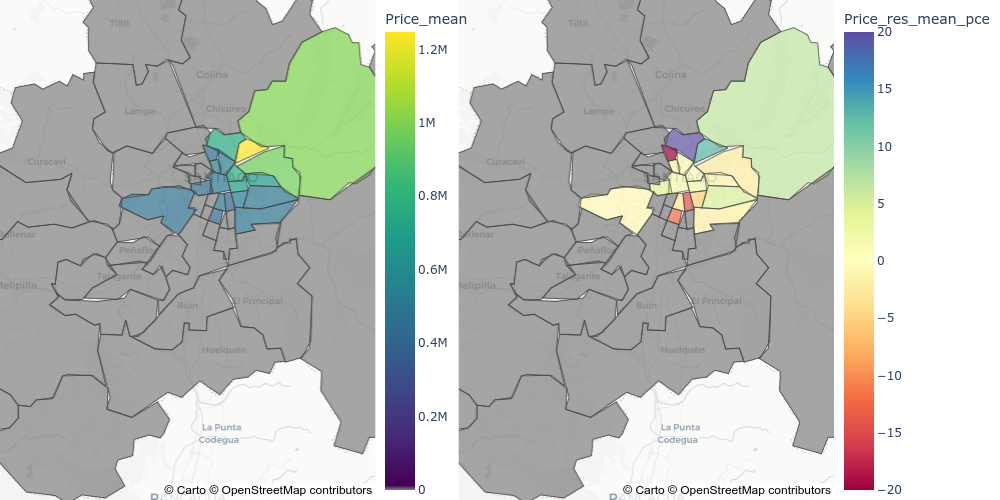

In [29]:
create_maps(
    df_test_surface_50_100_nonan, 
    geojson_mr, 
    features=['Price_mean','Price_res_mean_pce'], 
    colorscales=['viridis', 'spectral'],
    renderer='png',
    save_file='fig_price_test_surface_50_100'
)

### Predictions on test set: 100 < *Surface* < 600 [m2]

In [30]:
df_test_surface_100_600 = calculate_dataframe(
    df_test, 
    dct_locations, 
    features=['Price','Price_pred'], 
    z_feature='Surface', 
    z_min=100., 
    z_max=600.
)
df_test_surface_100_600_nonan = df_test_surface_100_600.fillna(value=dct_fillna)
df_test_surface_100_600_nonan.sort_values(by=['Location_count'], ascending=False)

,Price_mean,Price_pred_mean,Price_res_mean,Price_res_mean_pce,Location,Location_count,Location_id
2,1989799.0,1967584.0,22215.0,1.12,Las Condes,115.0,315
9,2115298.0,2184752.0,-69454.0,-3.28,Vitacura,67.0,334
3,2660453.0,2593008.0,67445.0,2.54,Lo Barnechea,38.0,316
6,1384674.0,1494979.0,-110305.0,-7.97,Providencia,23.0,324
8,2018653.0,1820600.0,198053.0,9.81,Santiago,4.0,333
0,1025400.0,1047622.0,-22222.0,-2.17,Huechuraba,2.0,308
5,1200000.0,1473800.0,-273800.0,-22.82,Penalolen,1.0,323
7,970000.0,1027364.0,-57364.0,-5.91,San Miguel,1.0,331
4,1300000.0,1473929.0,-173929.0,-13.38,Nunoa,1.0,321
1,857146.0,826607.0,30539.0,3.56,La Reina,1.0,314


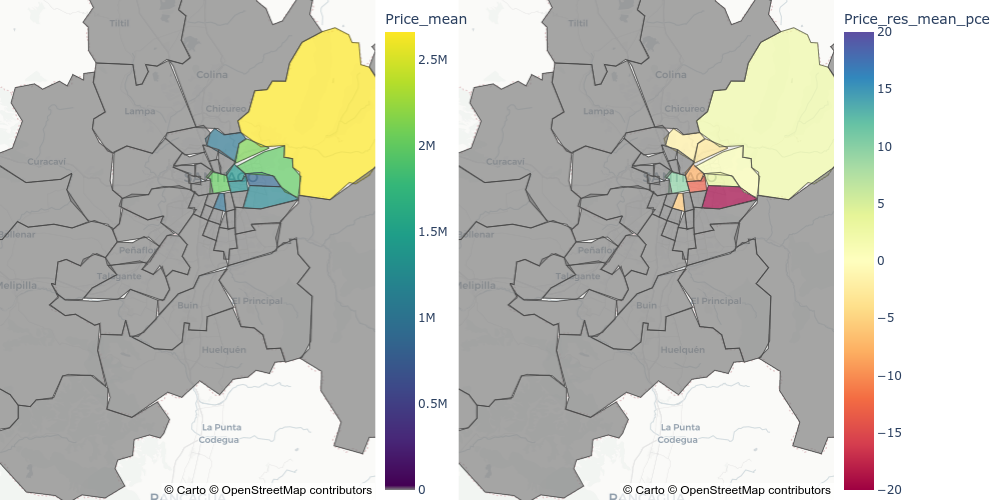

In [31]:
create_maps(
    df_test_surface_100_600_nonan, 
    geojson_mr, 
    features=['Price_mean','Price_res_mean_pce'], 
    colorscales=['viridis', 'spectral'],
    renderer='png',
    save_file='fig_price_test_surface_100_600'
)

The geospatial distributions shown here represent data that can be naturally visualized using any geographic information system (GIS) software.
To that end, we will add this data to the properties of the GeoJSON features which describe the geometry of the available locations. The generated GeoJSON is used to create the layers in a QGIS project stored in *../qgis/home-prices-santiago.qgz*. These layers show the same distributions using similar color scales as shown here, althought in slightly different ranges of values.  

In [32]:
id_column = 'Location_id'
add_columns = ['Price_mean','Price_pred_mean','Price_res_mean','Price_res_mean_pce','Location_count']

_ = add_dataframe_to_geojson(df_train_surface_0_50, geojson_mr, id_column, add_columns=add_columns, add_suffix='train_surface_0_50')
_ = add_dataframe_to_geojson(df_train_surface_50_100, geojson_mr, id_column, add_columns=add_columns, add_suffix='train_surface_50_100')
_ = add_dataframe_to_geojson(df_train_surface_100_600, geojson_mr, id_column, add_columns=add_columns, add_suffix='train_surface_100_600')
_ = add_dataframe_to_geojson(df_test_surface_0_50, geojson_mr, id_column, add_columns=add_columns, add_suffix='test_surface_0_50')
_ = add_dataframe_to_geojson(df_test_surface_50_100, geojson_mr, id_column, add_columns=add_columns, add_suffix='test_surface_50_100')
_ = add_dataframe_to_geojson(df_test_surface_100_600, geojson_mr, id_column, add_columns=add_columns, add_suffix='test_surface_100_600')

# save geojson containing additional properties
with open('../qgis/chile_comunas_MR_2.geojson', 'w') as f:
    json.dump(geojson_mr, f)

Additionally, we can calculate summary dataframes to facilitate the comparison between price residuals (as percentage of true prices; *Price_rmp* in following dataframes) obtained in the train and test sets over the available locations.

In [33]:
df_sum_s0_50 = df_train_surface_0_50_nonan.sort_values(by=['Location'], ascending=True)[['Location','Price_res_mean_pce','Location_count']].copy()
df_sum_s0_50 = df_sum_s0_50.reset_index(drop=True)
df_sum_s0_50 = df_sum_s0_50.rename(columns={
    "Price_res_mean_pce": "Price_rmp_train_s0_50",
    "Location_count": "Loc_count_train_s0_50" 
})
df_sum_s0_50['Price_rmp_test_s0_50'] = df_test_surface_0_50_nonan.sort_values(by=['Location'], ascending=True)['Price_res_mean_pce'].values
df_sum_s0_50['Loc_count_test_s0_50'] = df_test_surface_0_50_nonan.sort_values(by=['Location'], ascending=True)['Location_count'].values
# df_sum_s0_50.sort_values(by=['Price_rmp_test_s0_50'], ascending=False)
df_sum_s0_50.sort_values(by=['Price_rmp_train_s0_50'], ascending=False)

,Location,Price_rmp_train_s0_50,Loc_count_train_s0_50,Price_rmp_test_s0_50,Loc_count_test_s0_50
18,La Reina,21.82,3.0,0.00,0.0
21,Lo Barnechea,10.59,6.0,0.00,0.0
51,Vitacura,9.33,6.0,3.89,2.0
43,San Joaquin,7.17,16.0,4.33,11.0
15,La Florida,3.18,57.0,4.77,10.0
35,Providencia,2.20,60.0,9.19,9.0
45,San Miguel,1.65,129.0,4.30,32.0
24,Macul,1.45,31.0,1.88,6.0
28,Nunoa,1.36,87.0,-3.58,17.0
20,Las Condes,0.93,89.0,-4.08,19.0


In [34]:
df_sum_s50_100 = df_train_surface_50_100_nonan.sort_values(by=['Location'], ascending=True)[['Location','Price_res_mean_pce','Location_count']].copy()
df_sum_s50_100 = df_sum_s50_100.reset_index(drop=True)
df_sum_s50_100 = df_sum_s50_100.rename(columns={
    "Price_res_mean_pce": "Price_rmp_train_s50_100",
    "Location_count": "Loc_count_train_s50_100" 
})
df_sum_s50_100['Price_rmp_test_s50_100'] = df_test_surface_50_100_nonan.sort_values(by=['Location'], ascending=True)['Price_res_mean_pce'].values
df_sum_s50_100['Loc_count_test_s50_100'] = df_test_surface_50_100_nonan.sort_values(by=['Location'], ascending=True)['Location_count'].values
# df_sum_s50_100.sort_values(by=['Price_rmp_test_s50_100'], ascending=False)
df_sum_s50_100.sort_values(by=['Price_rmp_train_s50_100'], ascending=False)

,Location,Price_rmp_train_s50_100,Loc_count_train_s50_100,Price_rmp_test_s50_100,Loc_count_test_s50_100
19,Lampa,14.88,1.0,0.00,0.0
4,Cerro Navia,7.56,1.0,0.00,0.0
43,San Joaquin,2.63,3.0,-14.61,2.0
18,La Reina,2.63,14.0,-1.33,3.0
24,Macul,2.15,49.0,-5.09,2.0
28,Nunoa,1.76,146.0,1.84,17.0
21,Lo Barnechea,1.46,75.0,6.63,12.0
48,Santiago,1.29,221.0,1.61,46.0
35,Providencia,0.87,146.0,0.08,17.0
45,San Miguel,0.87,96.0,-2.99,17.0


In [35]:
df_sum_s100_600 = df_train_surface_100_600_nonan.sort_values(by=['Location'], ascending=True)[['Location','Price_res_mean_pce','Location_count']].copy()
df_sum_s100_600 = df_sum_s100_600.reset_index(drop=True)
df_sum_s100_600 = df_sum_s100_600.rename(columns={
    "Price_res_mean_pce": "Price_rmp_train_s100_600",
    "Location_count": "Loc_count_train_s100_600" 
})
df_sum_s100_600['Price_rmp_test_s100_600'] = df_test_surface_100_600_nonan.sort_values(by=['Location'], ascending=True)['Price_res_mean_pce'].values
df_sum_s100_600['Loc_count_test_s100_600'] = df_test_surface_100_600_nonan.sort_values(by=['Location'], ascending=True)['Location_count'].values
# df_sum_s100_600.sort_values(by=['Price_rmp_test_s100_600'], ascending=False)
df_sum_s100_600.sort_values(by=['Price_rmp_train_s100_600'], ascending=False)

,Location,Price_rmp_train_s100_600,Loc_count_train_s100_600,Price_rmp_test_s100_600,Loc_count_test_s100_600
18,La Reina,4.04,11.0,3.56,1.0
15,La Florida,3.48,1.0,0.00,0.0
5,Colina,2.94,1.0,0.00,0.0
51,Vitacura,1.15,325.0,-3.28,67.0
21,Lo Barnechea,1.13,161.0,2.54,38.0
35,Providencia,0.94,98.0,-7.97,23.0
20,Las Condes,0.89,617.0,1.12,115.0
36,Pudahuel,0.00,0.0,0.00,0.0
29,Padre Hurtado,0.00,0.0,0.00,0.0
30,Paine,0.00,0.0,0.00,0.0


## Conclusions 

The following are some of the conclusions we can derive from the figures and dataframes presented above: 

- A general geospatial pattern can be observed from the figures above, in which a larger fraction of the apartments having smaller *Surface* (0 - 50 m2) in the training and test sets are located in south-central locations (*Santiago*, *Estacion Central*, *San Miguel*).
These locations, which are the most popular choice of accommodation among middle to low-income inhabitants, contrast with north-east locations (*Las Condes*, *Vitacura*, *Lo Barnechea*) where most of larger apartments (*Surface* of 100 - 600 m2) as well as largely high income inhabitants tend to concentrate.
In between, midsize apartments (*Surface* of 50 - 100 m2) can be mostly found precisely in locations where a transition from middle-to-high income takes place (*Santiago*, *Ñuñoa*, *Providencia*, *Las Condes*).
This stratified pattern, therefore, reflects how socioeconomic inequalities existent in the Santiago Metropolitan Region of Chile have been reproduced by differences in the spatial distribution of the existent real state market. <br>

- In all the interval of *Surface* values considered (0 - 50, 50 - 100, and 100 - 600 m2), locations with significantly fewer data points (low *Location_count*) tend to show higher residuals in both training and test set. Whereas residuals are consistently low in locations with higher number of data points. This indicates, as we would expect, that having enough amount of data leads to powerful predictive model performance, reflected in the accurate predictions observed in the train set and test sets. <br>

- For a few locations, price residuals (*Price_rmp*) in the training set are very low, but significantly higher in the test set.
This is the case of *Providencia*, where the discrepancy between training and test residuals is of ~7% for *Surface* intervals between 0 - 50 and 100 - 600 m2. 
Likewise, the difference in train and test residuals is ~10% in *Santiago* for the *Surface* intervals between 100 - 600 m2.
These discrepancies in residuals may be an indication of overfitting, which could be overcome by including additional listings from these locations and *Surface* intervals, and subsequently retraining the selected models. <br> 

- On the other hand, high price residuals (*Price_rmp*) are observed in both the training and test sets for the location *Quinta Normal*. Here residuals are higher than 12% for *Surface* intervals between 0 - 50 and 50 - 100 m2, despite the fact that there are presumably sufficient data samples in the training set.
This could be a sign of underfitting, which may be caused by data that is more complex (harder to learn by the models) than for other locations.
Adding more of this data would likely improve the accuracy of the model predictions. <br>

- As an additional attempt to improve the accuracy of model predictions, we can try decreasing the threshold used (50 data points) when applying Dimensionality Reduction on the feature *Location*.
Although this would increase the number of features in the trained models and therefore also the models complexity, hence longer computational time may be required during the model training.